In [43]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
data = pd.read_csv('../ground_truths/ground_truth.csv')
data.head()


,tag,text,stage_level
0,<p>,Because stage 0 NSCLC is limited to the lining...,0.0
1,<p>,"If you are healthy enough for surgery, you can...",0.0
2,<p>,"For some stage 0 cancers, treatments such as p...",0.0
3,<p>,"If you have stage I NSCLC, surgery may be the ...",1.0
4,<p>,Segmentectomy or wedge resection is generally ...,1.0


In [9]:
doc = ['\n \n sss'] + list(data['text'].values)

In [11]:
# Remove new line characters
doc = [re.sub('\n+', ' ', sent) for sent in doc]

In [13]:
pprint(doc[:2])

['   sss',
 'Because stage 0 NSCLC is limited to the lining layer of airways and has not '
 'invaded deeper into the lung tissue or other areas, it is usually curable by '
 'surgery alone. No chemotherapy or radiation therapy is needed.']


In [14]:
# Remove punctuations, tokenizing
def sent_to_words(sentences):
    for sentence in sentences:
        yield gensim.utils.simple_preprocess(str(sentence), deacc=True)

In [15]:
data_words = list(sent_to_words(doc))
pprint(data_words[:2])





[['sss'],
 ['because',
  'stage',
  'nsclc',
  'is',
  'limited',
  'to',
  'the',
  'lining',
  'layer',
  'of',
  'airways',
  'and',
  'has',
  'not',
  'invaded',
  'deeper',
  'into',
  'the',
  'lung',
  'tissue',
  'or',
  'other',
  'areas',
  'it',
  'is',
  'usually',
  'curable',
  'by',
  'surgery',
  'alone',
  'no',
  'chemotherapy',
  'or',
  'radiation',
  'therapy',
  'is',
  'needed']]


In [17]:
# Creating Bigram and Trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
# higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[1]]])


['because', 'stage', 'nsclc', 'is', 'limited', 'to', 'the', 'lining', 'layer', 'of', 'airways', 'and', 'has', 'not', 'invaded', 'deeper', 'into', 'the', 'lung', 'tissue', 'or', 'other', 'areas', 'it', 'is', 'usually', 'curable', 'by', 'surgery', 'alone', 'no', 'chemotherapy', 'or', 'radiation', 'therapy', 'is', 'needed']


In [71]:
nlp = spacy.load('en', disable=['parser', 'ner'])
from spacy.lang.en.stop_words import STOP_WORDS


In [36]:
# Remove stopwords, make biagrams and lemmatize

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in STOP_WORDS] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [39]:
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:3])

[[], ['limit', 'line', 'layer', 'airway', 'invade', 'deep', 'lung', 'tissue', 'area', 'usually', 'curable', 'surgery', 'chemotherapy', 'radiation', 'therapy', 'need'], ['healthy', 'surgery', 'usually', 'treat', 'cancer', 'location', 'windpipe', 'divide', 'leave', 'right', 'main', 'bronchi', 'treat', 'resection', 'case', 'hard', 'remove', 'completely', 'remove', 'lobectomy', 'entire', 'lung', 'pneumonectomy']]


In [41]:
# Create the Dictionary and Corpus
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:2])

[[], [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1)]]


In [42]:
# Corpus format: (word_id: freq)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]]




[[],
 [('airway', 1),
  ('area', 1),
  ('chemotherapy', 1),
  ('curable', 1),
  ('deep', 1),
  ('invade', 1),
  ('layer', 1),
  ('limit', 1),
  ('line', 1),
  ('lung', 1),
  ('need', 1),
  ('radiation', 1),
  ('surgery', 1),
  ('therapy', 1),
  ('tissue', 1),
  ('usually', 1)]]

In [44]:
# Choose the optimal number of topics
# By choosing a 'k' that gives the highest coherence value

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


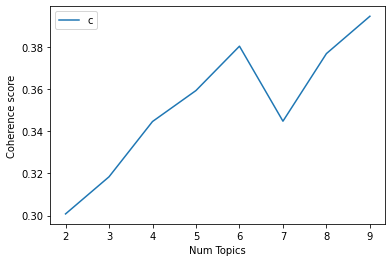

In [46]:
limit=10; start=2; step=1
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start, limit=limit, step=step)
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


In [54]:
# Select the model with num_topics=6
def select_model(model_list, num_topics_desired: int, start, step):
    model_idx = (num_topics_desired - start) / step
    return model_list[int(model_idx)]

model = select_model(model_list,
                     num_topics_desired=6,
                     start=start,
                     step=step)

In [55]:
# Show the topics
model_topics = model.show_topics(formatted=False)
pprint(model.print_topics(num_words=10))

[(0,
  '0.055*"cancer" + 0.050*"treatment" + 0.038*"surgery" + 0.030*"radiation" + '
  '0.029*"lung" + 0.026*"people" + 0.025*"option" + 0.021*"stage" + '
  '0.021*"remove" + 0.017*"treat"'),
 (1,
  '0.045*"treatment" + 0.034*"cancer" + 0.025*"help" + 0.019*"remove" + '
  '0.018*"node" + 0.017*"therapy" + 0.016*"cell" + 0.014*"pembrolizumab" + '
  '0.014*"tumor" + 0.014*"likely"'),
 (2,
  '0.069*"cancer" + 0.036*"surgery" + 0.035*"people" + 0.032*"cell" + '
  '0.030*"drug" + 0.022*"gene" + 0.020*"change" + 0.019*"treatment" + '
  '0.019*"option" + 0.018*"remove"'),
 (3,
  '0.056*"treatment" + 0.041*"radiation" + 0.039*"therapy" + 0.038*"cancer" + '
  '0.034*"surgery" + 0.018*"tumor" + 0.017*"lung" + 0.016*"option" + '
  '0.015*"stage" + 0.015*"treat"'),
 (4,
  '0.034*"patient" + 0.019*"spread" + 0.019*"widely" + 0.018*"well" + '
  '0.018*"lobectomy" + 0.018*"health" + 0.018*"offer" + 0.018*"tolerate" + '
  '0.018*"option" + 0.018*"generally"'),
 (5,
  '0.062*"treatment" + 0.028*"stage"

In [56]:
# Find the dominant topic in each paragraph

def format_topics_sentences(lda_model, corpus, texts):
    sent_topics_df = pd.DataFrame()
    for i, row in enumerate(lda_model[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Sort by word frequency
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = lda_model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df

In [70]:
df_topic_sents_keywords = format_topics_sentences(lda_model=model, corpus=corpus, texts=doc)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.1667,"cancer, treatment, surgery, radiation, lung, p...",sss
1,1,3.0,0.9509,"treatment, radiation, therapy, cancer, surgery...",Because stage 0 NSCLC is limited to the lining...
2,2,0.0,0.9650,"cancer, treatment, surgery, radiation, lung, p...","If you are healthy enough for surgery, you can..."
3,3,3.0,0.9301,"treatment, radiation, therapy, cancer, surgery...","For some stage 0 cancers, treatments such as p..."
4,4,2.0,0.9505,"cancer, surgery, people, cell, drug, gene, cha...","If you have stage I NSCLC, surgery may be the ..."


In [64]:
# Find the most representative document for each topic

def top_k_docs_for_each_topic(k):
    topic_representatives = pd.DataFrame()
    for i, group in df_dominant_topic.groupby('Dominant_Topic'):
        topic_representatives = pd.concat([topic_representatives,
                                                 group.sort_values(['Topic_Perc_Contrib'], ascending=[0]).head(k)],
                                                axis=0)
    topic_representatives.reset_index(drop=True, inplace=True)

    # Format
    # topic_representatives.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

    return topic_representatives


# Show
top_k_docs_for_each_topic(2).head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,32,0.0,0.9747,"cancer, treatment, surgery, radiation, lung, p...",If the cancer has caused fluid buildup in the ...
1,33,0.0,0.9711,"cancer, treatment, surgery, radiation, lung, p...","As with other stages, treatment for stage IV l..."
2,10,1.0,0.9581,"treatment, cancer, help, remove, node, therapy...",Any lymph nodes likely to have cancer in them ...
3,29,1.0,0.9557,"treatment, cancer, help, remove, node, therapy...",Your tumor cells might also be tested for the ...
4,28,2.0,0.9814,"cancer, surgery, people, cell, drug, gene, cha...","For tumors that have the ALK gene change, an A..."


In [69]:
topic_counts

0.0    13
2.0     8
3.0     8
1.0     3
5.0     2
4.0     2
Name: Dominant_Topic, dtype: int64

In [77]:
# Topic volume distribution
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = top_k_docs_for_each_topic(1)[['Dominant_Topic', 'Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics


,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"cancer, treatment, surgery, radiation, lung, p...",13,0.3611
1.0,1.0,"treatment, cancer, help, remove, node, therapy...",3,0.0833
2.0,2.0,"cancer, surgery, people, cell, drug, gene, cha...",8,0.2222
3.0,3.0,"treatment, radiation, therapy, cancer, surgery...",8,0.2222
4.0,4.0,"patient, spread, widely, well, lobectomy, heal...",2,0.0556
5.0,5.0,"treatment, stage, surgery, radiation, medical,...",2,0.0556


In [78]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.012148 -0.005545       1        1  27.262835
0      0.010798 -0.076126       2        1  23.844416
1      0.006213 -0.103707       3        1  17.473715
4      0.144050  0.079171       4        1  16.166750
2     -0.122819  0.062393       5        1   9.302531
3     -0.050389  0.043814       6        1   5.949749, topic_info=              Term       Freq      Total Category  logprob  loglift
17          cancer  33.000000  33.000000  Default  30.0000  30.0000
12         surgery  21.000000  21.000000  Default  29.0000  29.0000
55          option  12.000000  12.000000  Default  28.0000  28.0000
29          remove  11.000000  11.000000  Default  27.0000  27.0000
136  pembrolizumab   4.000000   4.000000  Default  26.0000  26.0000
..             ...        ...        ...      ...      ...      ...
230    information   0.087726   1.356117   Topic6  -6.1812   0.0837
46           tumor   0.615816   9.896460   Topic6  -4.2325   0.0448
17          cancer   1.673078  33.499916   Topic6  -3.2330  -0.1751
29          remove   0.616458  11.652543   Topic6  -4.2314  -0.1175
37       treatment   0.615821  30.669769   Topic6  -4.2325  -1.0863

[305 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
115       5  0.736935    adjuvant
165       2  0.463165    advanced
165       5  0.463165    advanced
0         2  0.656592      airway
180       1  0.926620         alk
...     ...       ...         ...
177       2  0.463168      widely
177       5  0.463168      widely
156       6  0.802029  widespread
33        1  0.641146    windpipe
149       1  0.640892        year

[348 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 2, 5, 3, 4])